# **Restorasi Citra Digital dengan Pendekatan Partial Differetial Equation (PDEs)**
---
---
Authors:
- Taufik Faturahman
- Audi Cipta Bakti
- Nunun Abdurahman
- Rima Rizita

In [0]:
# Melakukan clone untuk mendapatkan dataset gambar
!git clone https://github.com/taufikfathurahman/dataset.git
!ls /content/dataset/MCE3_Final_Project

fatal: destination path 'dataset' already exists and is not an empty directory.
'[damaged]test_image_1.png'    '[original]test_image_1.png'
'[damaged]test_image_2_1.png'  '[original]test_image_2.png'
'[damaged]test_image_2_2.png'  '[original]test_image_3.JPG'
'[damaged]test_image_2_3.png'  '[original]test_image_3.png'
'[damaged]test_image_3.png'


In [0]:
import cv2
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class ImageRestorer:
    """
    Melakukan restorasi terhadap gambar dengan menghilangkan object yang tidak
    diinginkan dengan menggunakan PDE.

    Parameter
    ---------
    img_dmgd : gambar yang akan direstorasi.
    img_orig : gambar asli yang akan digunakan sebagai pembanding, dan mendapatkan mask.
    max_iter : banyaknya iterasi yang akan dilakukan dalam merestorasi gambar.
    method   : metode yang akan digunakan, terdapat dua pilihan yaitu:
               - Diffusion
               - Perona Malik

    return   : gambar yang telah direstorasi.
    """

    def __init__(self, img_dmgd, img_orig, max_iter=50, method='diffusion'):
        self.img_dmgd = img_dmgd
        self.img_orig = img_orig
        self.max_iter = max_iter
        self.method = method
        self.img_mask = (img_orig - img_dmgd).astype(np.bool)

    def get_neighborhood(self, nd_idx, image):
        """
        mengembalikan tetangga dari index tertentu suatu gambar input.
        """
        u1 = image[nd_idx[0] + 1, nd_idx[1]]
        u2 = image[nd_idx[0] - 1, nd_idx[1]]
        u3 = image[nd_idx[0], nd_idx[1] + 1]
        u4 = image[nd_idx[0], nd_idx[1] - 1]

        return u1, u2, u3, u4

    def generate_kernel(self):
        """
        mengembalikan list dari array kernel.
        """

        kernel = [
                  np.array([[0, 1, 0],
                            [0, -1, 0],
                            [0, 0, 0]]),
                  np.array([[0, 0, 0],
                            [0, -1, 0],
                            [0, 1, 0]]),
                  np.array([[0, 0, 0],
                            [0, -1, 1],
                            [0, 0, 0]]),
                  np.array([[0, 0, 0],
                            [1, -1, 0],
                            [0, 0, 0]]),
                  np.array([[0, 0, 1],
                            [0, -1, 0],
                            [0, 0, 0]]),
                  np.array([[0, 0, 0],
                            [0, -1, 0],
                            [0, 0, 1]]),
                  np.array([[0, 0, 0],
                            [0, -1, 0],
                            [1, 0, 0]]),
                  np.array([[1, 0, 0],
                            [0, -1, 0],
                            [0, 0, 0]])
                  ]
        
        return kernel

    def diffusion_method(self):
        """
        melakukan restorasi gambar terhadap area yang ditentukan dengan mask
        menggunakan metode diffusion.
        """

        D = 1
        dx = 1
        p = 0.001
        mask_pts = np.array(np.where(self.img_mask)).T

        for mask_pt_n, mask_pt_idx in enumerate(mask_pts):
            u1, u2, u3, u4 = self.get_neighborhood(mask_pt_idx, self.img_dmgd)
            u = (D/dx**2)*np.average([u1, u2, u3, u4]) - 4 * p * int(self.img_dmgd[mask_pt_idx[0], mask_pt_idx[1]])           
            self.img_dmgd[mask_pt_idx[0], mask_pt_idx[1]] = int(u)

        restored_img = self.img_dmgd

        return restored_img

    def perona_malik_method(self):
        """
        melakukan restorasi gambar terhadap area yang ditentukan dengan mask
        menggunakan metode perona malik.
        """
        
        im_new = np.zeros(np.shape(self.img_dmgd))
        mask_pts = np.array(np.where(self.img_mask)).T
        windows = self.generate_kernel()
        delta = 0.1
        kappa = 15
        nab = [ndimage.filters.convolve(self.img_dmgd, w) for w in windows]
        gpm1 = [1 / (1 + (n / kappa) ** 2) for n in nab]
        res = [gpm1[i] * nab[i] for i in range(8)]
        res = delta * sum(res)

        for mask_pt_n, mask_pt_idx in enumerate(mask_pts):
            im_new[mask_pt_idx[0], mask_pt_idx[1]] = res[mask_pt_idx[0], mask_pt_idx[1]]

        restored_img = self.img_dmgd + im_new
        
        return restored_img

    def run(self):
        """
        melakukan eksekusi restorasi gambar berdasarkan parameter input.
        """
        img_restored = None
        if self.method.lower() == 'diffusion':
            for i in range(self.max_iter):
                img_restored = self.diffusion_method()
                self.img_dmgd = img_restored
        elif self.method.lower() == 'perona_malik':
            for i in range(self.max_iter):
                img_restored = self.perona_malik_method()
                self.img_dmgd = img_restored

        return img_restored

# *** Inisialisasi Parameter**

In [0]:
# Membaca gambar yang akan digunakan
origimg_filename = "/content/dataset/MCE3_Final_Project/[original]test_image_3.png"
dmgdimg_filename = "/content/dataset/MCE3_Final_Project/[damaged]test_image_3.png"

damaged_img = cv2.imread(dmgdimg_filename)
original_img = cv2.imread(origimg_filename)

# Ubah gambar kedalam grayscale
img_dmgd = cv2.cvtColor(damaged_img, cv2.COLOR_BGR2GRAY)
img_orig = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

# Init maksimum iterasi dan metode yang akan digunakan
MAX_ITER = 3000
METHOD1 = 'diffusion'
METHOD2 = 'perona_malik'

# *** Visualisasi Gambar yang Akan Diolah**

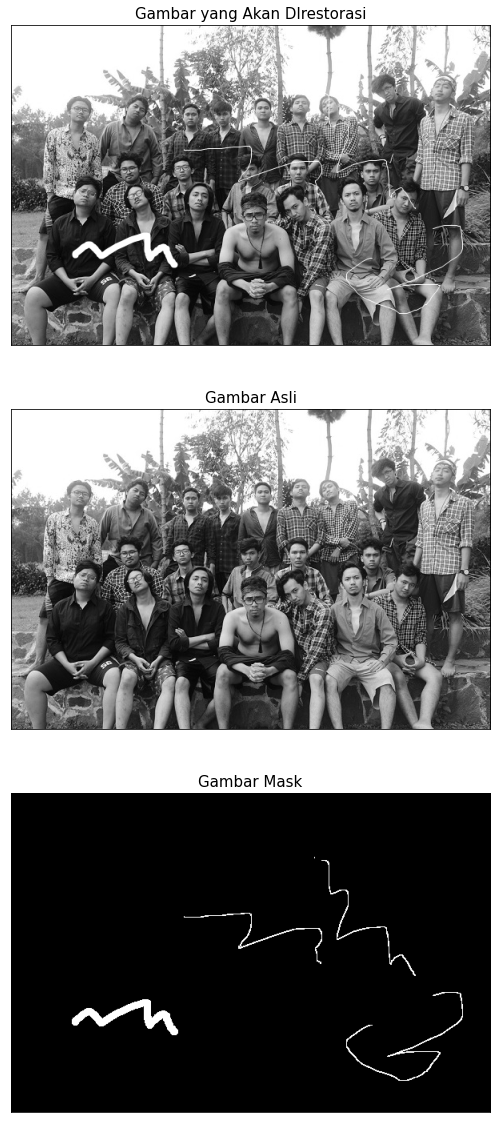

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10,20))

ax1.set_title('Gambar yang Akan DIrestorasi', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.imshow(img_dmgd, cmap='gray')

ax2.set_title('Gambar Asli', fontsize=15)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.imshow(img_orig, cmap='gray')

ax3.set_title('Gambar Mask', fontsize=15)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.imshow((img_orig - img_dmgd).astype(np.bool), cmap='gray')

plt.savefig('visualisasi gambar input.png')
plt.show()

# *** Eksekusi Image Restorasi**

### - Dengan Metode DIffusion

In [0]:
diff_result = ImageRestorer(img_dmgd, img_orig, max_iter=MAX_ITER, method=METHOD1).run()

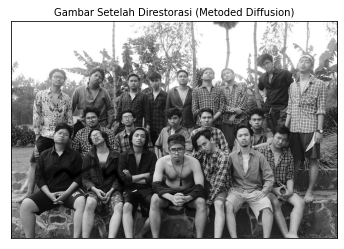

In [0]:
plt.title('Gambar Setelah Direstorasi (Metoded Diffusion)', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(diff_result, cmap='gray')
plt.savefig('restored image (diffusion).png')
plt.show()

### - Dengan Metode Perona Malik

In [0]:
pm_result = ImageRestorer(img_dmgd, img_orig, max_iter=MAX_ITER, method=METHOD2).run()

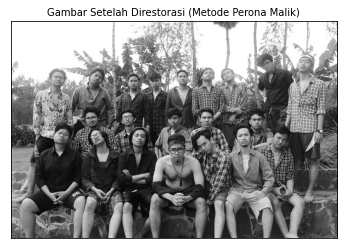

In [0]:
plt.title('Gambar Setelah Direstorasi (Metode Perona Malik)', fontsize=10)
plt.xticks([])
plt.yticks([])
plt.imshow(pm_result, cmap='gray')
plt.savefig('restored image (perona malik).png')
plt.show()